**Moving Average**
---

**Moving Average Smoothing**\
Smoothing is a technique applied to time series to remove the fine-grained variation between time steps.

The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes. Moving averages are a simple and common type of smoothing used in time series analysis and time series forecasting.

Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.

In [4]:
import pandas as pd
from matplotlib import pyplot

In [2]:
data = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv'
series = pd.read_csv(data, header=0, index_col=0, parse_dates=True, squeeze=True)

/var/folders/7f/4z7lvktj44g121hm_1s6v18h0000gn/T/ipykernel_85329/3018246214.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv(data, header=0, index_col=0, parse_dates=True, squeeze=True)


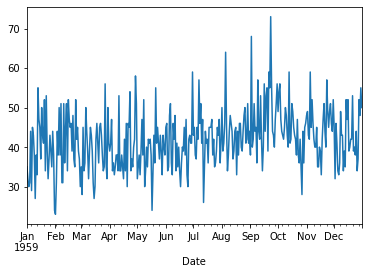

In [5]:
series.plot()
pyplot.show()

**1. Moving Average as Data Preparation**

Moving average can be used as a data preparation technique to create a smoothed version of the original dataset.

Smoothing is useful as a data preparation technique as it can reduce the random variation in the observations and better expose the structure of the underlying causal processes.

The rolling() function on the Series Pandas object will automatically group observations into a window. You can specify the window size, and by default a trailing window is created. Once the window is created, we can take the mean value, and this is our transformed dataset.

New observations in the future can be just as easily transformed by keeping the raw values for the last few observations and updating a new average value.

To make this concrete, with a window size of 3, the transformed value at time (t) is calculated as the mean value for the previous 3 observations (t-2, t-1, t), as follows:

`
obs(t) = 1/3 * (t-2 + t-1 + t)`\

Below is an example of transforming the Daily Female Births dataset into a moving average with a window size of 3 days, chosen arbitrarily.

Date
1959-01-01          NaN
1959-01-02          NaN
1959-01-03    32.333333
1959-01-04    31.000000
1959-01-05    35.000000
1959-01-06    34.666667
1959-01-07    39.333333
1959-01-08    39.000000
1959-01-09    42.000000
1959-01-10    36.000000
Name: Births, dtype: float64


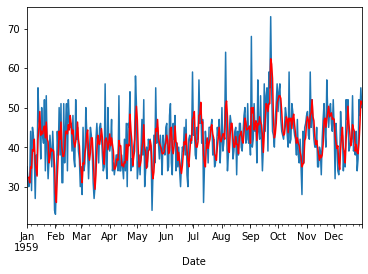

In [6]:
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()

` Raw plotted in blue and moving average in red`

**2. Moving Average as Feature Engineering**

The moving average can be used as a source of new information when modeling a time series forecast as a supervised learning problem.

In this case, the moving average is calculated and added as a new input feature used to predict the next time step.

`#Steps:`

First, a copy of the series must be shifted forward by one time step. This will represent the input to our prediction problem, or a `lag=1` version of the series. This is a standard supervised learning view of the time series problem. 

Next, a second copy of the series needs to be shifted forward by one, minus the window size. This is to ensure that the moving average summarizes the last few values and does not include the value to be predicted in the average, which would be an invalid framing of the problem as the input would contain knowledge of the future being predicted.

In [7]:
df = pd.DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, df], axis=1)
dataframe.columns = ['mean', 't-1', 't+1']
print(dataframe.head(10))

        mean   t-1  t+1
0        NaN   NaN   35
1        NaN  35.0   32
2        NaN  32.0   30
3        NaN  30.0   31
4  32.333333  31.0   44
5  31.000000  44.0   29
6  35.000000  29.0   45
7  34.666667  45.0   43
8  39.333333  43.0   38
9  39.000000  38.0   27


We can see that the first 4 rows cannot be used and must be discarded. The first row of the lag1 dataset cannot be used because there are no previous observations to predict the first observation, therefore a NaN value is used.

**3. Moving Average as Prediction**

The moving average value can also be used directly to make predictions.

It is a naive model and assumes that the trend and seasonality components of the time series have already been removed or adjusted for.

The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day.

We can implement this manually in Python. Below is an example of the moving average model used in a walk-forward manner.

predicted=32.333333, expected=31.000000
predicted=31.000000, expected=44.000000
predicted=35.000000, expected=29.000000
predicted=34.666667, expected=45.000000
predicted=39.333333, expected=43.000000
predicted=39.000000, expected=38.000000
predicted=42.000000, expected=27.000000
predicted=36.000000, expected=38.000000
predicted=34.333333, expected=33.000000
predicted=32.666667, expected=55.000000
predicted=42.000000, expected=47.000000
predicted=45.000000, expected=45.000000
predicted=49.000000, expected=37.000000
predicted=43.000000, expected=50.000000
predicted=44.000000, expected=43.000000
predicted=43.333333, expected=41.000000
predicted=44.666667, expected=52.000000
predicted=45.333333, expected=34.000000
predicted=42.333333, expected=53.000000
predicted=46.333333, expected=39.000000
predicted=42.000000, expected=32.000000
predicted=41.333333, expected=37.000000
predicted=36.000000, expected=43.000000
predicted=37.333333, expected=39.000000
predicted=39.666667, expected=35.000000


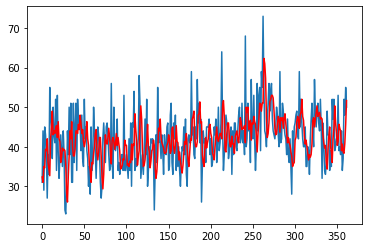

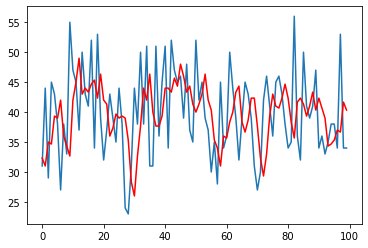

In [8]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# prepare situation
X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='red')
pyplot.show()

In [10]:
test, predictions = test[0:100], predictions[0:100]

In [13]:
# import lets_plot
from lets_plot import *
LetsPlot.setup_html()
